# Preprocessing and Prepare data input

In [1]:
import os
import glob
import numpy as np
import xarray as xr
import rioxarray as rxr
from preprocess import utils_climate


**Dữ liệu tĩnh**

In [2]:
import numpy as np
from scipy.ndimage import generic_filter
import xarray as xr

def local_mean_fill(da: xr.DataArray, size=3):
    arr = da.values
    nan_mask = np.isnan(arr)

    def nanmean_filter(x):
        x = x[~np.isnan(x)]
        return np.mean(x) if x.size > 0 else np.nan

    local_means = generic_filter(arr, nanmean_filter, size=size, mode='mirror')
    
    filled_arr = arr.copy()
    filled_arr[nan_mask] = local_means[nan_mask]
    
    # Gán lại vào DataArray, giữ nguyên tọa độ
    return xr.DataArray(filled_arr, coords=da.coords, dims=da.dims, attrs=da.attrs)

In [3]:
# Thư mục dữ liệu
DATA_ROOT = "/mnt/storage/code/pywapor-clms/dataset/dataset_TayNguyen"

# Đọc DEM tĩnh
dem_files = {
    "z": f"{DATA_ROOT}/dem/elevation_2000-01-01.tif",
    "slope": f"{DATA_ROOT}/dem/slope_2000-01-01.tif",
    "aspect": f"{DATA_ROOT}/dem/aspect_2000-01-01.tif",
    "t_amp": f"{DATA_ROOT}/t_amp/temp_amplitude_annual_2023-01-01.tif",  # nếu có
}

static_vars = {}
template = rxr.open_rasterio("/mnt/storage/code/pywapor-clms/dataset/dataset_TayNguyen/sm/sm_for_ndvi_2023-01-01.tif", masked=True).squeeze()

for var, path in dem_files.items():
    da = rxr.open_rasterio(path, masked=True).squeeze()

    if var == 'slope':
        da = utils_climate.degree_to_radian(da)

    da = utils_climate.resample_to_100m_match_template(da, template)

    # Fill NaN bằng local mean
    da = local_mean_fill(da)

    static_vars[var] = da


In [4]:
static_vars['aspect'].values

array([[ 90.     , 172.66667, 226.     , ..., 111.     , 104.     ,
        296.     ],
       [ 90.     , 146.42857, 270.     , ..., 157.     , 111.     ,
        207.     ],
       [123.     , 180.     ,  46.     , ..., 188.     , 314.     ,
        279.     ],
       ...,
       [ 64.     , 252.     ,  54.     , ..., 146.     , 296.     ,
         27.     ],
       [244.     ,  72.     , 338.     , ..., 197.125  , 296.     ,
        256.     ],
       [343.     , 351.     ,  16.     , ..., 123.     , 296.     ,
        116.     ]], dtype=float32)

**Dữ liệu động (46 ngày NDVI, albedo, SM, thời tiết)**

In [5]:

from datetime import datetime
def get_list_date(folder_ndvi):
    """get list date of NDVI in series 

    Args:
        folder_ndvi (type: str): path to folder contain list NDVI image. 

    Returns:
        dict: list of all date follow to NDVI date.
    """
    list_name = os.listdir(folder_ndvi)
    list_dates = []
    for name in list_name:
        date_str = name.split('_')[-1].split('.')[0]
        list_dates.append(date_str)
    # Parse strings to datetime objects for accurate sorting
    list_dates_sorted = sorted(list_dates, key=lambda d: datetime.strptime(d, '%Y-%m-%d'))
    return list_dates_sorted

In [6]:
folder_ndvi = '/mnt/storage/code/pywapor-clms/dataset/dataset_TayNguyen/ndvi'
list_dates = get_list_date(folder_ndvi)

In [7]:
data_vars = {
    "t_air_24": [],
    "t_air_min_24": [],
    "t_air_max_24": [],
    "t_dew_24": [],
    "p_air_0_24": [],
    "u2m_24": [],
    "v2m_24": [],
    "p_24": [],
    "ra_flat_24": [],
    "albedo": [],
    "ndvi": [],
    "se_root": []
}

# Mapping từ tên biến cho vào file gốc
var_map = {
    "t_air_24": "temperature_2m",
    "t_air_min_24": "temperature_2m_min",
    "t_air_max_24": "temperature_2m_max",
    "t_dew_24": "dewpoint_temperature_2m",
    "p_air_0_24": "surface_pressure",
    "u2m_24": "u_component_of_wind_10m",
    "v2m_24": "v_component_of_wind_10m",
    "p_24": "total_precipitation_sum",
    "ra_flat_24": "surface_net_solar_radiation_sum"
}

def load_var(name, date, prefix="era5"):
    f = glob.glob(f"{DATA_ROOT}/{prefix}/{date}/{name}_{date}.tif")
    if not f:
        print(f"⚠️ Missing: {prefix}/{date}/{name}_{date}.tif")
        return None

    da = rxr.open_rasterio(f[0], masked=True).squeeze()
    da = utils_climate.resample_to_100m_match_template(da, template)

    if name in ['temperature_2m', 'temperature_2m_min', 'temperature_2m_max', 'dewpoint_temperature_2m']:
        return utils_climate.kevin_to_celcius(da)
    elif name == 'surface_net_solar_radiation_sum':
        return utils_climate.jun_to_mjun(da)
    elif name == 'surface_pressure':
        return utils_climate.pa_to_kpa(da)
    else:
        return da

valid_dates = []

for date in list_dates:
    day_path = os.path.join(DATA_ROOT, "era5", date)
    if not os.path.exists(day_path):
        print(f"❌ Era5 path not found for {date}")
        continue

    skip_date = False
    for var_key, filename_prefix in var_map.items():
        da = load_var(filename_prefix, date)
        if da is not None:
            if not isinstance(da, xr.DataArray):
                da = xr.DataArray(da)
            data_vars[var_key].append(local_mean_fill(da))
        else:
            skip_date = True
            break

    albedo_file = f"{DATA_ROOT}/albedo_s2/albedo_{date}.tif"
    if os.path.exists(albedo_file):
        albedo_da = rxr.open_rasterio(albedo_file, masked=True).squeeze()
        albedo_da = utils_climate.resample_to_100m_match_template(albedo_da,template)
        data_vars["albedo"].append(local_mean_fill(albedo_da))
    else:
        print(f"⚠️ Albedo file not found for {date}")
        skip_date = True


    ndvi_file = f"{DATA_ROOT}/ndvi/ndvi8days_infer_{date}.tif"
    if os.path.exists(ndvi_file):
        ndvi_da = rxr.open_rasterio(ndvi_file, masked=True).squeeze()
        ndvi_da = utils_climate.resample_to_100m_match_template(ndvi_da,template)
        data_vars["ndvi"].append(local_mean_fill(ndvi_da))
    else:
        print(f"⚠️ NDVI file not found for {date}")
        skip_date = True

    
    sm_file = f"{DATA_ROOT}/sm/sm_for_ndvi_{date}.tif"
    if os.path.exists(sm_file):
        sm_da = rxr.open_rasterio(sm_file, masked=True).squeeze()
        sm_da = sm_da.fillna(1)
        data_vars["se_root"].append(sm_da)

        # test sm ful 1
        # sm_da = rxr.open_rasterio(sm_file, masked=True).squeeze()
        # sm_da.data[:] = 1 
        # data_vars["se_root"].append(sm_da)
    else:
        print(f"⚠️ NDVI file not found for {date}")
        skip_date = True

    if not skip_date:
        valid_dates.append(date)



In [16]:
data_vars['ndvi'][0].values.shape

(41, 42)

In [8]:
data_vars['se_root'][45].values

array([[0.34734327, 0.3687427 , 0.35824913, ..., 0.33686692, 0.3287258 ,
        0.3141093 ],
       [0.34016   , 0.3477351 , 0.34640092, ..., 0.34639513, 0.33480942,
        0.32199386],
       [0.31334192, 0.32067153, 0.31231028, ..., 0.34607762, 0.34953973,
        0.33709598],
       ...,
       [0.36574113, 0.35943115, 0.34913102, ..., 0.37317482, 0.4173844 ,
        0.40181202],
       [0.33319923, 0.32322484, 0.3688262 , ..., 0.40062246, 0.3819711 ,
        0.40533772],
       [0.34706658, 0.36205086, 0.39110875, ..., 0.3717884 , 0.38258964,
        0.3878566 ]], dtype=float32)

In [9]:
data_vars.keys()

dict_keys(['t_air_24', 't_air_min_24', 't_air_max_24', 't_dew_24', 'p_air_0_24', 'u2m_24', 'v2m_24', 'p_24', 'ra_flat_24', 'albedo', 'ndvi', 'se_root'])

In [10]:
import geopandas as gpd

# Đọc file GeoJSON
gdf = gpd.read_file("/mnt/storage/code/pywapor-clms/geo_json/TayNguyen.geojson")

# Lấy điểm trung tâm (centroid)
centroid = gdf.geometry.centroid.iloc[0]

# Tọa độ trung tâm
lon, lat = centroid.x, centroid.y

print(f"🧭 Tọa độ trung tâm: (lon: {lon}, lat: {lat})")


🧭 Tọa độ trung tâm: (lon: 108.005347, lat: 12.443784)


/tmp/ipykernel_6639/203285915.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf.geometry.centroid.iloc[0]


In [11]:
region = 'TayNguyen'
def prepare_data_input(static_vars, data_vars, index, date):
    coords = {
        "x": static_vars["slope"].coords["x"],
        "y": static_vars["slope"].coords["y"],
        "time_bins": [np.datetime64(date)]
    }

    ds = xr.Dataset(
        data_vars=dict(
            doy=(("time_bins",), [utils_climate.date_to_doy(date)]),  # mở rộng theo time_bins
            ndvi=(("y", "x"), data_vars["ndvi"][index].values),
            ra_flat_24=(("y", "x"), data_vars["ra_flat_24"][index].values),
            slope=(("y", "x"), static_vars["slope"].values),
            aspect=(("y", "x"), static_vars["aspect"].values),
            p_air_0_24=(("y", "x"), data_vars["p_air_0_24"][index].values),
            z=(("y", "x"), static_vars["z"].values),
            t_dew_24=(("y", "x"), data_vars["t_dew_24"][index].values),
            t_air_24=(("y", "x"), data_vars["t_air_24"][index].values),
            t_air_min_24=(("y", "x"), data_vars["t_air_min_24"][index].values),
            t_air_max_24=(("y", "x"), data_vars["t_air_max_24"][index].values),
            se_root=(("y", "x"), data_vars["se_root"][index].values),
            u2m_24=(("y", "x"), data_vars["u2m_24"][index].values),
            v2m_24=(("y", "x"), data_vars["v2m_24"][index].values),
            p_24=(("y", "x"), data_vars["p_24"][index].values),
            t_amp=(("y", "x"), static_vars["t_amp"].values),
            r0 = (("y", "x"), data_vars["albedo"][index].values)
        ),
        coords=coords,
    )
    
    ds.encoding["source"] = f"/mnt/storage/code/pywapor-clms/res_{region}/{date}/res_{date}"
    
    return ds


# **Calculating**

In [12]:
from pywapor.et_look import main

/home/nhatvm/miniconda3/envs/my_pywapor_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
date = '2023-01-01'
idx = 0 
print(f"Processing date: {date}")
ds_input = climate_preprocessor.prepare_data_input(static_vars, idx, date)
print(ds_input.values())

Processing date: 2023-01-01


NameError: name 'climate_preprocessor' is not defined

In [17]:
for idx, date in enumerate(list_dates):
    ds_input = prepare_data_input(static_vars, data_vars, idx, date)
    print(ds_input.keys())
 
    main(ds_input, et_look_version='v3', export_vars="default", chunks={})
    break

KeysView(<xarray.Dataset> Size: 187kB
Dimensions:       (time_bins: 1, y: 41, x: 42)
Coordinates:
    band          int64 8B 1
    spatial_ref   int64 8B 0
  * x             (x) float64 336B 108.0 108.0 108.0 108.0 ... 108.0 108.0 108.0
  * y             (y) float64 328B 12.46 12.46 12.46 12.46 ... 12.43 12.43 12.43
  * time_bins     (time_bins) datetime64[s] 8B 2023-01-01
Data variables: (12/17)
    doy           (time_bins) int64 8B 1
    ndvi          (y, x) float32 7kB 0.317 0.292 0.2375 ... 0.129 -0.06352
    ra_flat_24    (y, x) float64 14kB 8.145 8.145 8.145 ... 8.567 8.567 8.567
    slope         (y, x) float32 7kB 0.01745 0.05236 0.01745 ... 0.03491 0.03491
    aspect        (y, x) float32 7kB 90.0 172.7 226.0 46.0 ... 123.0 296.0 116.0
    p_air_0_24    (y, x) float64 14kB 96.43 96.43 96.43 ... 95.92 95.92 95.92
    ...            ...
    se_root       (y, x) float32 7kB 0.3385 0.3386 0.3407 ... 0.3653 0.358
    u2m_24        (y, x) float64 14kB -1.982 -1.982 -1.982 ... -1.55

# Check result

In [22]:
import xarray as xr

# Mở dataset từ file NetCDF

ds1 = xr.open_dataset("/mnt/storage/code/pywapor-clms/res_TayNguyen/2023-05-01/res_2023-05-01")

# Xem thông tin tổng quan dataset
print(ds1)

# Giả sử biến ET có tên là 'et' hoặc tương tự, kiểm tra danh sách biến
print(ds1.data_vars)

# Lấy biến ET ra (ví dụ 'et_reference_mm' hoặc 'et_look' tùy biến)
et_var_name = 'aeti_24_mm'  # thay bằng tên đúng nếu khác

if et_var_name in ds_input:
    et_data = ds_input[et_var_name]
    print(et_data)
    # Xem vài giá trị đầu tiên
    print(et_data.values[:10])
else:
    print(f"Biến {et_var_name} không có trong dataset")

<xarray.Dataset> Size: 70kB
Dimensions:      (y: 41, x: 42, time_bins: 1)
Coordinates:
  * x            (x) float64 336B 108.0 108.0 108.0 108.0 ... 108.0 108.0 108.0
  * y            (y) float64 328B 12.46 12.46 12.46 12.46 ... 12.43 12.43 12.43
  * time_bins    (time_bins) datetime64[ns] 8B 2023-05-01
Data variables:
    int_mm       (y, x) float64 14kB ...
    t_24_mm      (time_bins, y, x) float64 14kB ...
    e_24_mm      (time_bins, y, x) float64 14kB ...
    aeti_24_mm   (time_bins, y, x) float64 14kB ...
    se_root      (y, x) float64 14kB ...
    spatial_ref  int64 8B ...
Attributes:
    pyWaPOR_bb:      unknown
    pyWaPOR_period:  unknown
Data variables:
    int_mm       (y, x) float64 14kB ...
    t_24_mm      (time_bins, y, x) float64 14kB ...
    e_24_mm      (time_bins, y, x) float64 14kB ...
    aeti_24_mm   (time_bins, y, x) float64 14kB ...
    se_root      (y, x) float64 14kB ...
    spatial_ref  int64 8B ...
Biến aeti_24_mm không có trong dataset


In [23]:
for var in ds1.data_vars:
    print(f"== {var} ==")
    print(ds1[var].values)

== int_mm ==
[[0.000e+00 4.360e-06 1.450e-06 ... 2.239e-05 8.250e-06 9.890e-06]
 [0.000e+00 9.500e-07 7.100e-07 ... 1.117e-05 3.400e-05 8.860e-06]
 [4.150e-06 9.500e-07 0.000e+00 ... 4.499e-05 3.348e-05 3.333e-05]
 ...
 [6.080e-05 5.833e-05 4.570e-05 ... 6.551e-05 4.214e-05 6.014e-05]
 [6.436e-05 0.000e+00 7.670e-05 ... 4.583e-05 5.211e-05 5.021e-05]
 [4.152e-05 5.274e-05 5.668e-05 ... 4.854e-05 6.496e-05 5.536e-05]]
== t_24_mm ==
[[[4.52170000e-04 1.71958370e-01 5.61884800e-02 ... 7.00642780e-01
   2.05107060e-01 3.04898380e-01]
  [3.66120000e-04 3.08541700e-02 2.51544700e-02 ... 3.55031290e-01
   8.98179670e-01 3.13358940e-01]
  [1.68675020e-01 3.18340100e-02 2.51710000e-04 ... 1.22035752e+00
   8.61266040e-01 9.94555460e-01]
  ...
  [1.06521335e+00 1.04301676e+00 9.85134080e-01 ... 1.29348580e+00
   9.28571040e-01 1.31919519e+00]
  [1.15647896e+00 2.96530000e-04 1.56003883e+00 ... 9.83109860e-01
   1.06330951e+00 1.08580868e+00]
  [9.55677200e-01 1.35597188e+00 1.39345787e+00 ... 9.

In [24]:
et_values = ds1["aeti_24_mm"].compute().values
print("AETI (e_24_mm) values:", et_values)

# Nếu muốn xem dạng array 3D (time, y, x)
print("Shape:", et_values.shape)

# Nếu chỉ có 1 điểm như bạn, in giá trị đơn giản:
print(f"AETI 24h (mm): {et_values[0,0,0]}")


AETI (e_24_mm) values: [[[0.22397383 0.3702919  0.25079069 ... 0.84824145 0.32006803 0.4538119 ]
  [0.1796474  0.19239983 0.20198023 ... 0.50856388 1.00907552 0.48871451]
  [0.37514137 0.19874826 0.12018409 ... 1.32822417 0.96819985 1.12751196]
  ...
  [1.14689899 1.12909768 1.1092337  ... 1.38957683 1.05808931 1.43966325]
  [1.23933516 0.14915532 1.66051696 ... 1.10594868 1.17374877 1.20832579]
  [1.09454622 1.51989941 1.5431538  ... 0.99956842 1.28665494 1.12838751]]]
Shape: (1, 41, 42)
AETI 24h (mm): 0.22397383


**xuat ra anh tif**

In [25]:
import rasterio
from rasterio.transform import from_origin
import numpy as np


In [28]:
for date in list_dates:
    ds1 = xr.open_dataset(f"/mnt/storage/code/pywapor-clms/res_{region}/{date}/res_{date}")
    # Lấy giá trị
    aeti = ds1["aeti_24_mm"].isel(time_bins=0).values  # (y, x)
    aeti = np.squeeze(aeti)

    # Lấy thông tin tọa độ
    x = ds1.coords["x"].values
    y = ds1.coords["y"].values

    # Tính affine transform
    res_x = abs(x[1] - x[0])
    res_y = abs(y[1] - y[0])
    transform = from_origin(x[0] - res_x / 2, y[0] + res_y / 2, res_x, res_y)

    # Lưu GeoTIFF
    with rasterio.open(
        f"/mnt/storage/code/pywapor-clms/image/result_image_taynguyen/aete_res_{date}.tif",
        "w",
        driver="GTiff",
        height=aeti.shape[0],
        width=aeti.shape[1],
        count=1,
        dtype=aeti.dtype,
        crs="EPSG:4326",  
        transform=transform,
    ) as dst:
        dst.write(aeti, 1)
    

In [41]:
import rasterio
from rasterio.transform import from_origin
import numpy as np

# Lấy giá trị
aeti = ds1["aeti_24_mm"].isel(time_bins=0).values  # (y, x)
aeti = np.squeeze(aeti)

# Lấy thông tin tọa độ
x = ds1.coords["x"].values
y = ds1.coords["y"].values

# Tính affine transform
res_x = abs(x[1] - x[0])
res_y = abs(y[1] - y[0])
transform = from_origin(x[0] - res_x / 2, y[0] + res_y / 2, res_x, res_y)

# Lưu GeoTIFF
with rasterio.open(
    "aeti_24_v3_mm_sm_1_5_2023.tif",
    "w",
    driver="GTiff",
    height=aeti.shape[0],
    width=aeti.shape[1],
    count=1,
    dtype=aeti.dtype,
    crs="EPSG:4326",  # Hoặc CRS đúng từ ds1 nếu có
    transform=transform,
) as dst:
    dst.write(aeti, 1)


# 3 band to 1 band SM

In [28]:
import glob
import rasterio
input_folder = "/mnt/storage/code/pywapor-clms/dataset/sm/"
output_folder = "/mnt/storage/code/pywapor-clms/dataset/sm/"
os.makedirs(output_folder, exist_ok=True)

for tif_path in glob.glob(os.path.join(input_folder, "*.tif")):
    with rasterio.open(tif_path) as src:
        band1 = src.read(1)
        profile = src.profile.copy()
    
    profile.update({"count": 1, "dtype": band1.dtype, "compress": "lzw"})
    out_path = os.path.join(output_folder, os.path.basename(tif_path))
    
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(band1, 1)


# TEMP: XUAT FILE GEOJSON

In [56]:
import os
import json
import ee
import rasterio
from pyproj import Transformer

# Khởi tạo Earth Engine
ee.Initialize(project='ee-minhnhat8dc')

# Đường dẫn NDVI
folder_ndvi = '/mnt/storage/code/pywapor-clms/dataset/ndvi/'
list_dates = get_list_date(folder_ndvi)
ndvi_file = os.path.join(folder_ndvi, f"ndvi8days_infer_{list_dates[0]}.tif")

# Đọc bounds từ ảnh raster
with rasterio.open(ndvi_file) as src:
    bounds = src.bounds
    crs = src.crs

# Chuyển về EPSG:4326 (lat/lon)
transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
ll = transformer.transform(bounds.left, bounds.bottom)
lr = transformer.transform(bounds.right, bounds.bottom)
ur = transformer.transform(bounds.right, bounds.top)
ul = transformer.transform(bounds.left, bounds.top)
coords = [ul, ur, lr, ll, ul]

# Tạo polygon EE
region = ee.Geometry.Polygon([coords])

# Lấy GeoJSON dictionary
region_geojson = region.getInfo()

# Ghi ra file GeoJSON
output_path = "/mnt/storage/code/pywapor-clms/region.geojson"
with open(output_path, "w") as f:
    json.dump(region_geojson, f, indent=2)

print(f"✅ Đã lưu GeoJSON tại: {output_path}")


✅ Đã lưu GeoJSON tại: /mnt/storage/code/pywapor-clms/region.geojson


# Chuyen crs 300 ve 100 

In [19]:
import os
import glob
import xarray as xr
import rioxarray
from tqdm import tqdm

# ✅ Đường dẫn thư mục gốc chứa các ảnh
DATA_ROOT = "/mnt/storage/code/pywapor-clms/data_valid/AnBinh_KienXuong_ThaiBinh"

# ✅ Template image: ảnh gốc 100m dùng làm mẫu
TEMPLATE_PATH = f"/mnt/storage/code/pywapor-clms/dataset/sm/2023-01-01.tif"
template = rioxarray.open_rasterio(TEMPLATE_PATH, masked=True).squeeze()

# ✅ Thư mục output
OUTPUT_ROOT = f"{DATA_ROOT}_resampled_100m"

# ✅ Duyệt toàn bộ ảnh TIF trong thư mục gốc
tif_paths = glob.glob(f"{DATA_ROOT}/**/*.tif", recursive=True)

for tif_path in tqdm(tif_paths, desc="Resampling"):
    try:
        # Mở ảnh
        da = rioxarray.open_rasterio(tif_path, masked=True)
        da_resampled = utils_climate.resample_to_100m_match_template(da, template)

        # Tạo đường dẫn output tương ứng
        rel_path = os.path.relpath(tif_path, DATA_ROOT)
        output_path = os.path.join(OUTPUT_ROOT, rel_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Ghi file đã resample
        da_resampled.rio.to_raster(output_path)
    except Exception as e:
        print(f"❌ Error processing {tif_path}: {e}")


Resampling: 100%|██████████| 36/36 [00:00<00:00, 110.36it/s]


# Test MSE, RMSE of 2 image tif

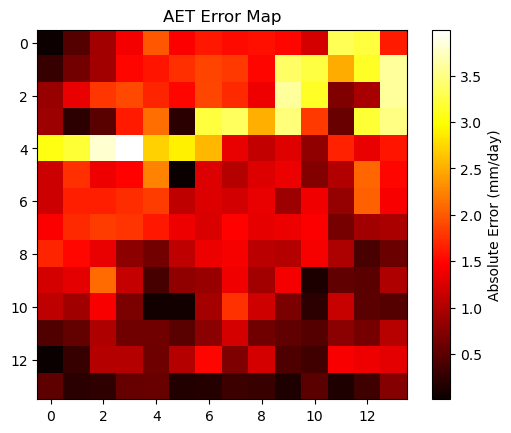

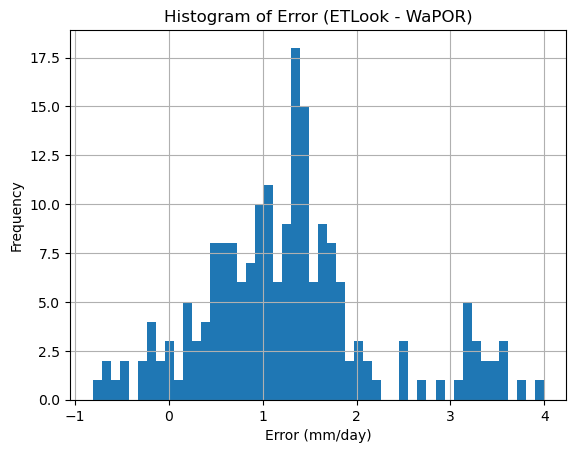

MSE: 2.4880
RMSE: 1.5773


In [ ]:
import rioxarray
import numpy as np
import matplotlib.pyplot as plt

def compute_mse_rmse(path1: str, path2: str):
    # Mở 2 ảnh và squeeze để loại chiều dư (nếu có band)
    img1 = rioxarray.open_rasterio(path1, masked=True).squeeze() * 0.1
    img2 = rioxarray.open_rasterio(path2, masked=True).squeeze()

    # Đảm bảo cùng shape
    if img1.shape != img2.shape:
        raise ValueError(f"Different shapes: {img1.shape} vs {img2.shape}")
    # Convert về numpy array
    arr1 = img1.values
    arr2 = img2.values
    # Mặt nạ hợp lệ: cả hai ảnh đều không bị mask
    mask = (~np.isnan(arr1)) & (~np.isnan(arr2))

    error_map = np.full_like(arr1, np.nan)
    error_map[mask] = np.abs(arr1[mask] - arr2[mask])

    plt.imshow(error_map, cmap="hot")
    plt.colorbar(label="Absolute Error (mm/day)")
    plt.title("AET Error Map")
    plt.show()
    # Tính MSE và RMSE
    mse = np.mean((arr1[mask] - arr2[mask]) ** 2)
    rmse = np.sqrt(mse)

    plt.hist(arr1[mask] - arr2[mask], bins=50)
    plt.title("Histogram of Error (ETLook - WaPOR)")
    plt.xlabel("Error (mm/day)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
    return mse, rmse

# 🔧 Ví dụ sử dụng:
path_img1 = "/mnt/storage/code/pywapor-clms/data_valid/cropped_images/WAPOR-3.L3-AETI-D.VTM.2023-01-D1.tif"
path_img2 = "/mnt/storage/code/pywapor-clms/aeti_resampled_to_300m_v3_sm_1_5_2023.tif"

mse, rmse = compute_mse_rmse(path_img1, path_img2)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


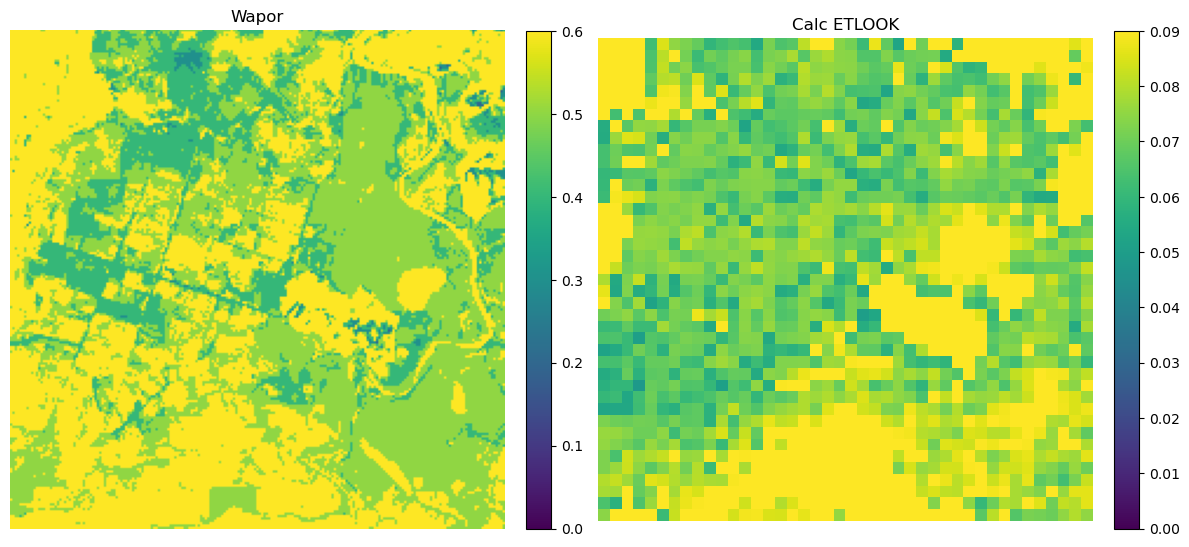

In [67]:
import rioxarray
import matplotlib.pyplot as plt

def show_two_images(path1: str, path2: str, titles=("Image 1", "Image 2"), cmap="viridis", vmin=0, vmax=4.5):
    # Đọc ảnh và squeeze để bỏ chiều band nếu có
    img1 = rioxarray.open_rasterio(path1, masked=True).squeeze() * 0.1
    img2 = rioxarray.open_rasterio(path2, masked=True).squeeze()

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    im1 = axs[0].imshow(img1, cmap=cmap, vmin=vmin, vmax=0.6)
    axs[0].set_title(titles[0])
    axs[0].axis("off")
    plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

    im2 = axs[1].imshow(img2, cmap=cmap, vmin=0, vmax=0.09)
    axs[1].set_title(titles[1])
    axs[1].axis("off")
    plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# 🔧 Ví dụ sử dụng
path_img1 = "/mnt/storage/code/pywapor-clms/data_valid/cropped_images/WAPOR-3.L3-AETI-D.VTM.2023-01-D1.tif"
path_img2 = "/mnt/storage/code/pywapor-clms/image/result_image_taynguyen/aete_res_2023-01-01.tif"

show_two_images(path_img1, path_img2, titles=["Wapor", "Calc ETLOOK"])


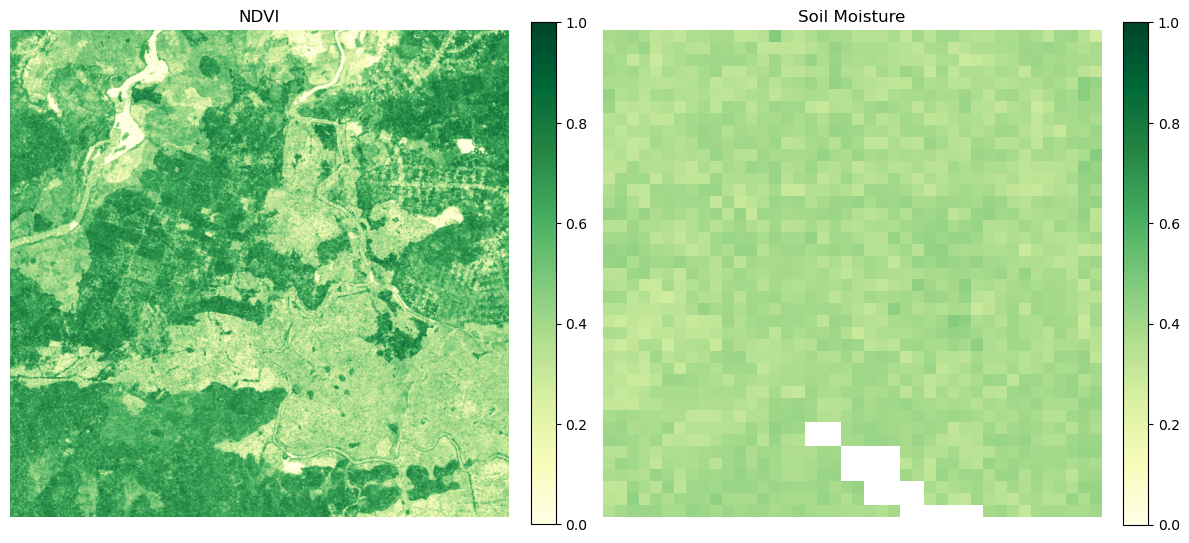

In [44]:
import rioxarray
import matplotlib.pyplot as plt

def show_two_images(path1: str, path2: str, titles=("Image 1", "Image 2"), cmap="viridis", vmin=None, vmax=None, scale1=1.0, scale2=1.0):
    # Đọc ảnh và scale
    img1 = rioxarray.open_rasterio(path1, masked=True).squeeze() * scale1
    img2 = rioxarray.open_rasterio(path2, masked=True).squeeze() * scale2

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    im1 = axs[0].imshow(img1, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_title(titles[0])
    axs[0].axis("off")
    plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

    im2 = axs[1].imshow(img2, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_title(titles[1])
    axs[1].axis("off")
    plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# 🧪 Ví dụ sử dụng: NDVI và SM
path_ndvi = "/mnt/storage/code/pywapor-clms/dataset/dataset_TayNguyen/ndvi/ndvi8days_infer_2023-12-03.tif"
path_sm = "/mnt/storage/code/pywapor-clms/dataset/dataset_TayNguyen/sm/sm_for_ndvi_2023-06-26.tif"

# NDVI thường trong khoảng -1 → 1
show_two_images(path_ndvi, path_sm, titles=["NDVI", "Soil Moisture"], cmap="YlGn", vmin=0, vmax=1)


In [26]:
import rioxarray
import numpy as np

# Đọc ảnh SM (giả sử bạn đang dùng định dạng GeoTIFF)
sm_path = "/mnt/storage/code/pywapor-clms/dataset/sm/2023-05-01.tif"
sm = rioxarray.open_rasterio(sm_path, masked=True).squeeze()

# Loại bỏ giá trị NaN
valid_sm = sm.values[~np.isnan(sm.values)]

# Tính min, max, mean
min_val = np.min(valid_sm)
max_val = np.max(valid_sm)
mean_val = np.mean(valid_sm)

print(f"SM range: {min_val:.4f} – {max_val:.4f}")
print(f"Mean SM: {mean_val:.4f}")


SM range: 0.3008 – 0.4352
Mean SM: 0.3473


📊 WaPOR stats:
  min: 0.2000
  max: 2.0000
  mean: 0.6102
  std: 0.2490

📊 ETLOOK stats:
  min: 0.0483
  max: 0.4948
  mean: 0.0972
  std: 0.0706


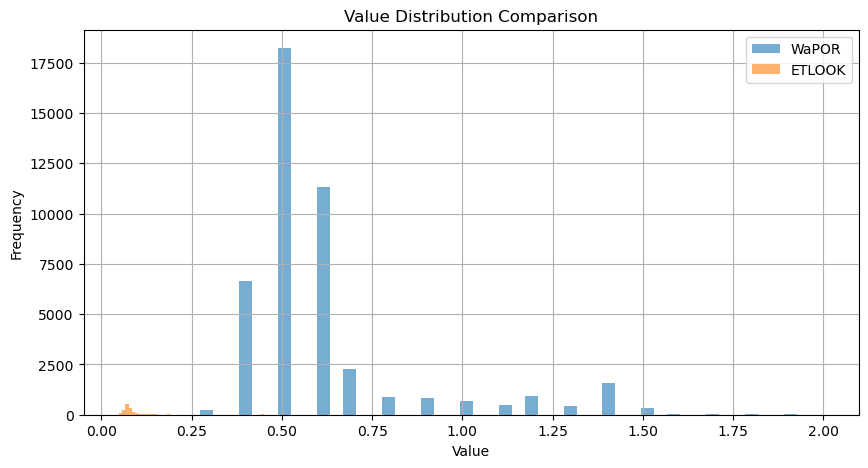

In [57]:
import rioxarray
import numpy as np
import matplotlib.pyplot as plt

def compare_stats_and_distribution(path1, path2, scale1=0.1, scale2=1.0, title1="Image 1", title2="Image 2"):
    # Mở ảnh và scale
    img1 = rioxarray.open_rasterio(path1, masked=True).squeeze() * scale1
    img2 = rioxarray.open_rasterio(path2, masked=True).squeeze() * scale2

    # Chuyển về numpy và loại giá trị NaN
    arr1 = img1.values
    arr2 = img2.values
    arr1_valid = arr1[~np.isnan(arr1)]
    arr2_valid = arr2[~np.isnan(arr2)]

    # So sánh thống kê
    def stats(arr):
        return {
            "min": np.min(arr),
            "max": np.max(arr),
            "mean": np.mean(arr),
            "std": np.std(arr)
        }

    stats1 = stats(arr1_valid)
    stats2 = stats(arr2_valid)

    print(f"📊 {title1} stats:")
    for k, v in stats1.items():
        print(f"  {k}: {v:.4f}")

    print(f"\n📊 {title2} stats:")
    for k, v in stats2.items():
        print(f"  {k}: {v:.4f}")

    # Vẽ histogram
    plt.figure(figsize=(10, 5))
    plt.hist(arr1_valid, bins=50, alpha=0.6, label=title1)
    plt.hist(arr2_valid, bins=50, alpha=0.6, label=title2)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title("Value Distribution Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

# 🧪 Gọi hàm
path_img1 = "/mnt/storage/code/pywapor-clms/data_valid/cropped_images/WAPOR-3.L3-AETI-D.VTM.2023-01-D1.tif"
path_img2 = "/mnt/storage/code/pywapor-clms/image/result_image_taynguyen/aete_res_2023-01-01.tif"

compare_stats_and_distribution(path_img1, path_img2, scale1=0.1, scale2=1.0,
                               title1="WaPOR", title2="ETLOOK")


# chuyển 100m về 300m 

In [43]:
import rioxarray as rxr

# Mở ảnh gốc 100m
da_100m = rxr.open_rasterio("/mnt/storage/code/pywapor-clms/aeti_24_v3_mm_sm_1_5_2023.tif", masked=True).squeeze()

# Mở ảnh mẫu 300m
template_300m = rxr.open_rasterio("/mnt/storage/code/pywapor-clms/cropped_WAPOR-3.L1-AETI-D.2023-01-D1_ef14dcbb.tif", masked=True).squeeze()

# Đảm bảo khớp CRS
if not da_100m.rio.crs:
    da_100m = da_100m.rio.write_crs(template_300m.rio.crs)

# Resample về 300m
da_300m = da_100m.rio.reproject_match(template_300m)

# Lưu ảnh mới ra file .tif
da_300m.rio.to_raster("aeti_resampled_to_300m_v3_sm_1_5_2023.tif")


In [36]:
import os 

In [ ]:
os.listdir

In [41]:
list_image = os.listdir('/mnt/storage/code/pywapor-clms/aeti_res_test')
root_path = '/mnt/storage/code/pywapor-clms/aeti_res_test'
output_folder= '/mnt/storage/code/pywapor-clms/aete_res_resampled'
for image in list_image:
    path = os.path.join(root_path,image)
    # Mở ảnh gốc 100m
    da_100m = rxr.open_rasterio(path, masked=True).squeeze()

    # Mở ảnh mẫu 300m
    template_300m = rxr.open_rasterio("/mnt/storage/code/pywapor-clms/data_valid/AnBinh_KienXuong_ThaiBinh/cropped_WAPOR-3.L1-AETI-D.2023-02-D2_e32758b1.tif", masked=True).squeeze()

    # Đảm bảo khớp CRS
    if not da_100m.rio.crs:
        da_100m = da_100m.rio.write_crs(template_300m.rio.crs)

    # Resample về 300m
    da_300m = da_100m.rio.reproject_match(template_300m)

    # Lưu ảnh mới ra file .tif
    da_300m.rio.to_raster(f"/mnt/storage/code/pywapor-clms/aete_res_resampled/{image}_resampled.tif")

# show anh AETI theo thoi gian

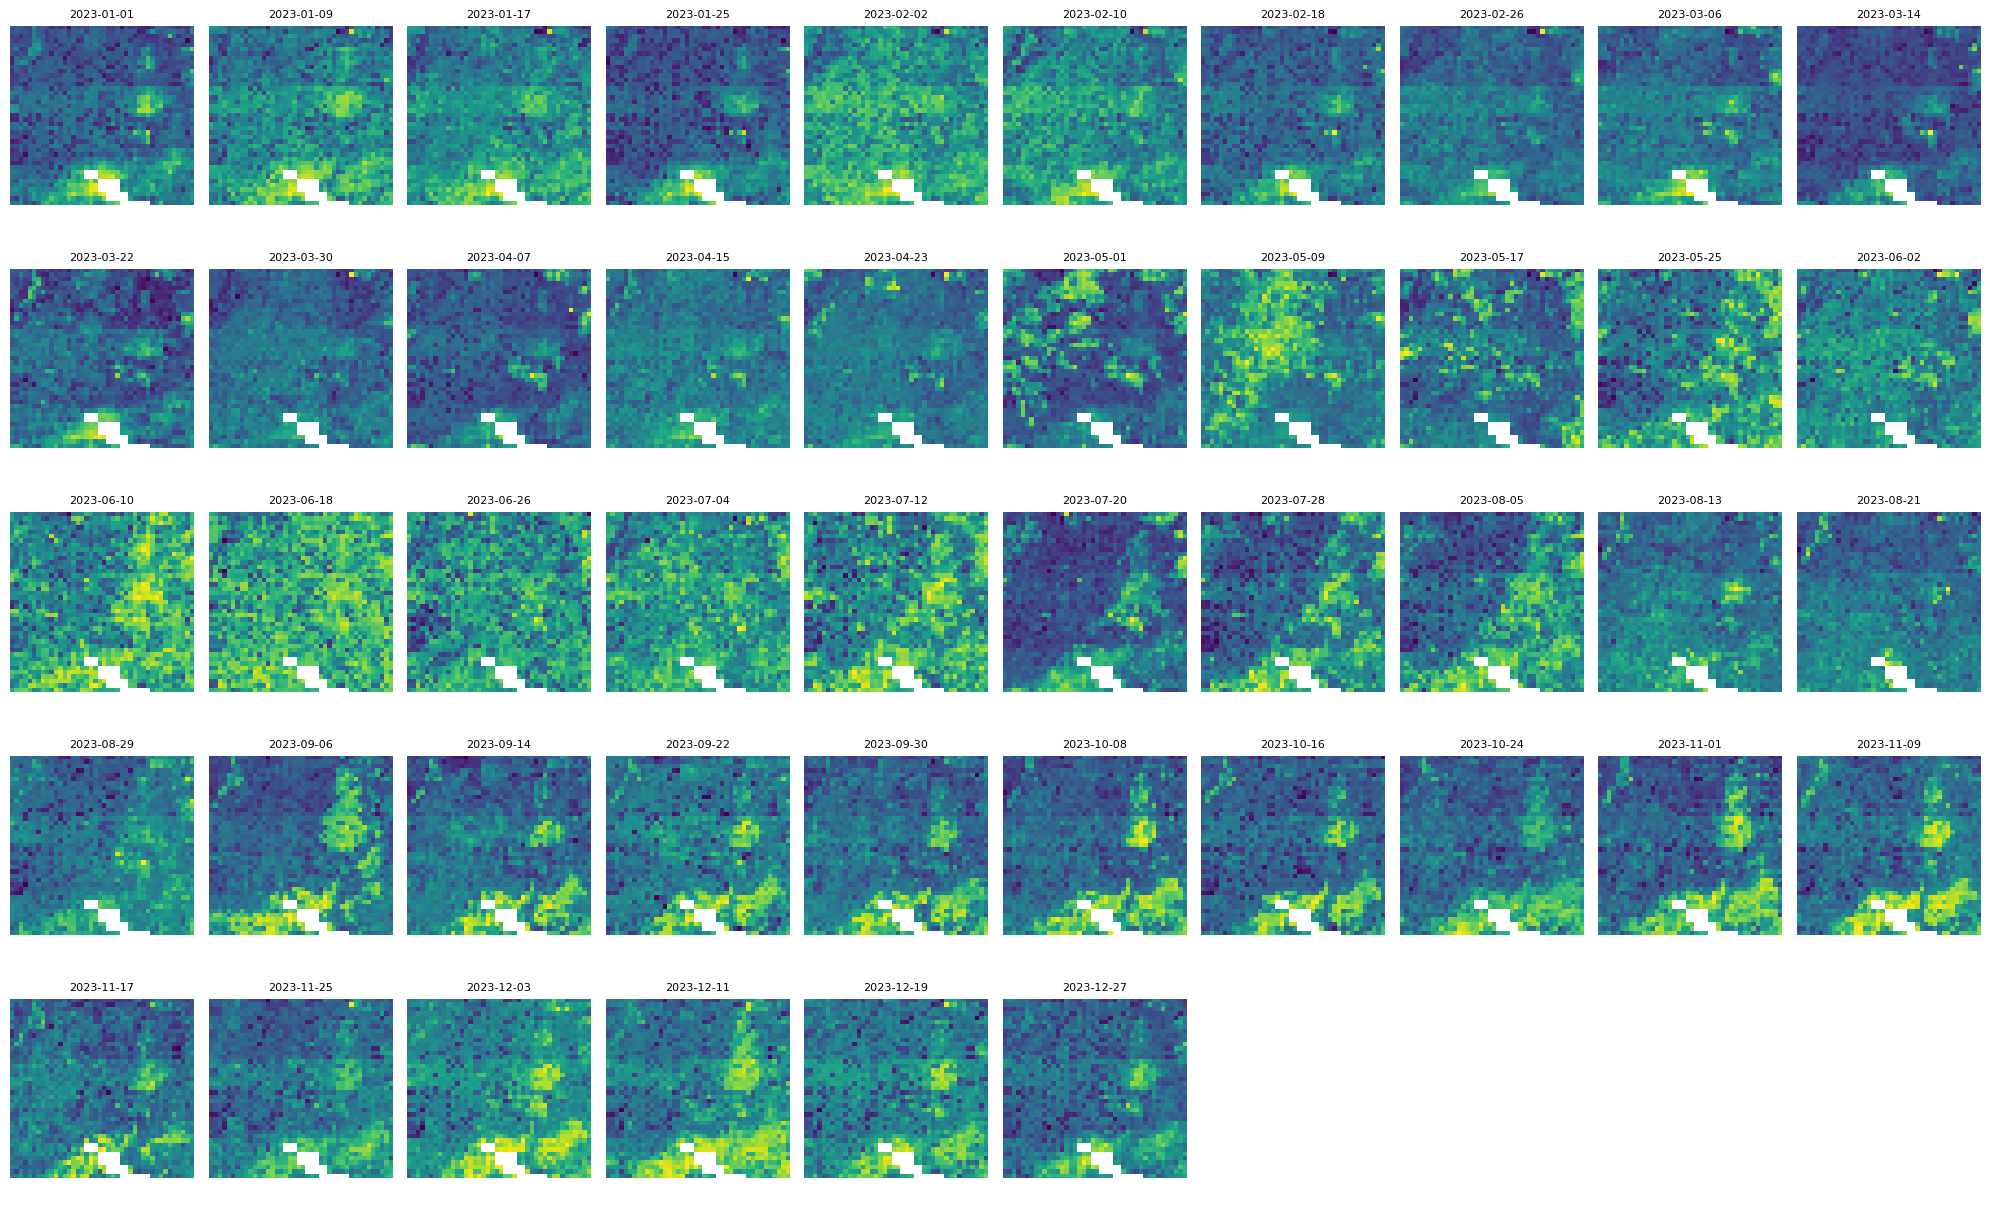

In [68]:
import os
import math
import matplotlib.pyplot as plt
import rasterio

# Đường dẫn thư mục chứa ảnh
folder_path = '/mnt/storage/code/pywapor-clms/dataset/dataset_TayNguyen/sm'

# Lấy danh sách file .tif
tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])

# Thông số hiển thị
images_per_row = 10
n_images = len(tif_files)
n_rows = math.ceil(n_images / images_per_row)

# Tạo figure
fig, axs = plt.subplots(n_rows, images_per_row, figsize=(20, 2.5 * n_rows))

# Nếu chỉ có 1 dòng, axs là 1D array
axs = axs.flatten()

# Vẽ từng ảnh vào subplot
for i, tif_file in enumerate(tif_files):
    file_path = os.path.join(folder_path, tif_file)
    
    with rasterio.open(file_path) as src:
        image = src.read(1)


    axs[i].imshow(image, cmap='viridis')
    axs[i].set_title(tif_file.split('_')[-1].split('.')[0], fontsize=8)
    axs[i].axis('off')

# Tắt subplot trống (nếu có)
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


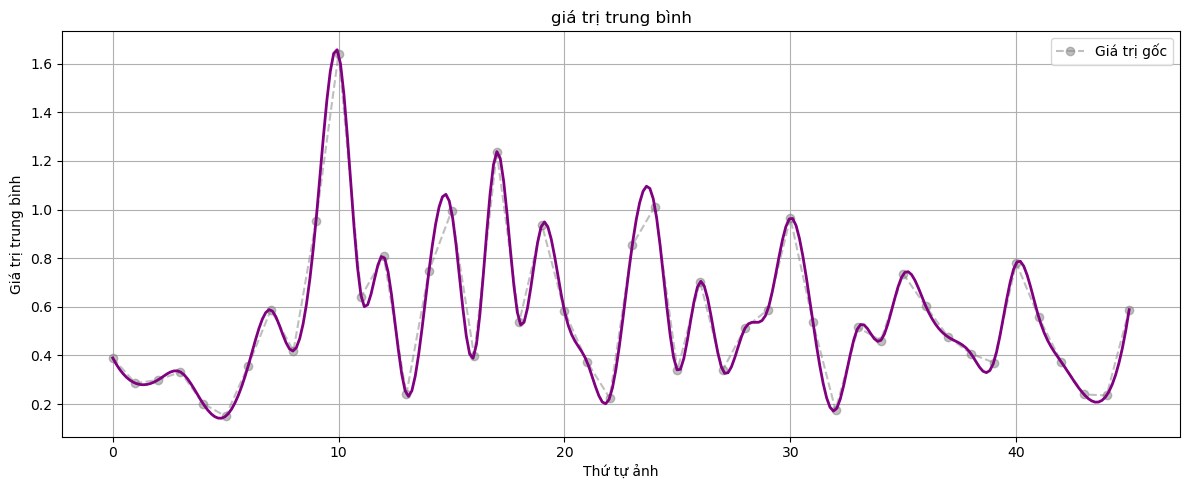

In [61]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from scipy.interpolate import make_interp_spline  # spline smoothing

# Hàm tính giá trị trung bình từng ảnh trong folder
def load_mean_values(folder_path):
    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])
    means = []

    for tif_file in tif_files:
        file_path = os.path.join(folder_path, tif_file)

        with rasterio.open(file_path) as src:
            image = src.read(1)

        valid_pixels = image[image != src.nodata] if src.nodata is not None else image
        mean_val = np.nanmean(valid_pixels)
        means.append(mean_val)

    return means


# Thư mục ảnh
folder = "/mnt/storage/code/pywapor-clms/image/result_image/aeti_res_test"

# Tính trung bình
means = load_mean_values(folder)
x = np.arange(len(means))


# Cách 2: Spline Interpolation (đường cong mượt hơn)
x_spline = np.linspace(x.min(), x.max(), 300)
spline = make_interp_spline(x, means, k=3)
y_spline = spline(x_spline)

# ---- Vẽ biểu đồ ---- #
plt.figure(figsize=(12, 5))
plt.plot(means, marker='o', linestyle='--', color='gray', label='Giá trị gốc', alpha=0.5)
# plt.plot(x_ma, smoothed_ma, color='green', linewidth=2, label='Mượt - Moving Avg')
plt.plot(x_spline, y_spline, color='purple', linestyle='-', linewidth=2)

plt.title('giá trị trung bình')
plt.xlabel('Thứ tự ảnh')
plt.ylabel('Giá trị trung bình')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
import os
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject

def resample_to_template(input_folder, output_folder, template_path):
    os.makedirs(output_folder, exist_ok=True)

    # Mở ảnh template
    with rasterio.open(template_path) as tmpl:
        dst_crs = tmpl.crs
        dst_transform = tmpl.transform
        dst_width = tmpl.width
        dst_height = tmpl.height
        dst_shape = (dst_height, dst_width)

    # Lấy danh sách ảnh gốc
    tif_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.tif')])

    for tif_file in tif_files:
        input_path = os.path.join(input_folder, tif_file)
        output_path = os.path.join(output_folder, tif_file)

        with rasterio.open(input_path) as src:
            # Tạo metadata mới theo template
            dst_meta = src.meta.copy()
            dst_meta.update({
                'crs': dst_crs,
                'transform': dst_transform,
                'width': dst_width,
                'height': dst_height
            })

            # Khởi tạo mảng đích
            dst_array = rasterio.band(src, 1).read(out_shape=dst_shape)
            dst_array = None
            dst_array = np.empty(dst_shape, dtype=np.float32)

            # Ghi ảnh đã resample
            with rasterio.open(output_path, 'w', **dst_meta) as dst:
                reproject(
                    source=rasterio.band(src, 1),
                    destination=dst_array,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.bilinear  # average nếu là dữ liệu tổng hợp
                )
                dst.write(dst_array, 1)

    print(f"✅ Đã resample {len(tif_files)} ảnh theo template và lưu tại: {output_folder}")

input_folder = '/mnt/storage/code/pywapor-clms/aeti_res_test'
output_folder = 'aete_res_resampled'
template_path = '/mnt/storage/code/pywapor-clms/data_valid/AnBinh_KienXuong_ThaiBinh/cropped_WAPOR-3.L1-AETI-D.2023-01-D1_ef14dcbb.tif'

resample_to_template(input_folder, output_folder, template_path)



AttributeError: 'Band' object has no attribute 'read'

In [6]:
import os
from datetime import datetime, timedelta

def find_closest_sm_date(ndvi_date, sm_dates, max_diff_days=5):
    """
    Tìm ngày SM gần nhất trong khoảng ±max_diff_days so với ngày NDVI.

    Args:
        ndvi_date (str): Ngày NDVI (định dạng 'YYYY-MM-DD').
        sm_dates (list): Danh sách các ngày SM (định dạng 'YYYY-MM-DD').
        max_diff_days (int): Số ngày chênh lệch tối đa (mặc định: 4).

    Returns:
        str: Ngày SM gần nhất hoặc None nếu không tìm thấy.
    """
    ndvi_date_obj = datetime.strptime(ndvi_date, '%Y-%m-%d')
    sm_date_objs = [datetime.strptime(sm_date, '%Y-%m-%d') for sm_date in sm_dates]

    # Tìm ngày SM gần nhất trong khoảng ±max_diff_days
    closest_date = None
    min_diff = timedelta(days=max_diff_days + 1)  # Khởi tạo với giá trị lớn hơn max_diff_days

    for sm_date in sm_date_objs:
        diff = abs(sm_date - ndvi_date_obj)
        if diff <= timedelta(days=max_diff_days) and diff < min_diff:
            closest_date = sm_date
            min_diff = diff

    return closest_date.strftime('%Y-%m-%d') if closest_date else None


def process_sm_files(ndvi_dates, sm_folder):
    """
    Đổi tên file SM theo ngày NDVI gần nhất và xóa các file không phù hợp.

    Args:
        ndvi_dates (list): Danh sách các ngày NDVI (định dạng 'YYYY-MM-DD').
        sm_folder (str): Đường dẫn thư mục chứa các file SM.
    """
    # Lấy danh sách file SM
    sm_files = [f for f in os.listdir(sm_folder) if f.endswith('.tif')]
    sm_dates = [f.split('.')[0] for f in sm_files]  # Giả sử tên file SM là "YYYY-MM-DD.tif"

    for ndvi_date in ndvi_dates:
        closest_sm_date = find_closest_sm_date(ndvi_date, sm_dates)
        if closest_sm_date:
            # Đổi tên file SM tương ứng
            old_file = os.path.join(sm_folder, f"{closest_sm_date}.tif")
            new_file = os.path.join(sm_folder, f"sm_for_ndvi_{ndvi_date}.tif")
            os.rename(old_file, new_file)
            print(f"✅ Đổi tên: {old_file} -> {new_file}")
        else:
            print(f"⚠️ Không tìm thấy SM phù hợp cho NDVI ngày {ndvi_date}")

    # Xóa các file SM không được sử dụng
    used_files = [f"sm_for_ndvi_{ndvi_date}.tif" for ndvi_date in ndvi_dates]
    for sm_file in sm_files:
        sm_file_path = os.path.join(sm_folder, f"{sm_file}.tif")
        if sm_file not in used_files:
            os.remove(sm_file_path)
            print(f"🗑️ Đã xóa: {sm_file_path}")


# Ví dụ sử dụng
if __name__ == "__main__":
    # Danh sách ngày NDVI
    ndvi_file_name = os.listdir('/mnt/storage/code/pywapor-clms/dataset/dataset_TayNguyen/ndvi')
    ndvi_dates = [f.split('_')[2].split('.')[0] for f in ndvi_file_name if f.endswith('.tif')]
    # Thư mục chứa file SM
    sm_folder = "/mnt/storage/code/pywapor-clms/sm-TN/sm"

    # Xử lý file SM
    process_sm_files(ndvi_dates, sm_folder)

✅ Đổi tên: /mnt/storage/code/pywapor-clms/sm-TN/sm/2023-06-05.tif -> /mnt/storage/code/pywapor-clms/sm-TN/sm/sm_for_ndvi_2023-06-10.tif
✅ Đổi tên: /mnt/storage/code/pywapor-clms/sm-TN/sm/2022-12-31.tif -> /mnt/storage/code/pywapor-clms/sm-TN/sm/sm_for_ndvi_2023-01-01.tif
✅ Đổi tên: /mnt/storage/code/pywapor-clms/sm-TN/sm/2023-01-07.tif -> /mnt/storage/code/pywapor-clms/sm-TN/sm/sm_for_ndvi_2023-01-09.tif
✅ Đổi tên: /mnt/storage/code/pywapor-clms/sm-TN/sm/2023-01-19.tif -> /mnt/storage/code/pywapor-clms/sm-TN/sm/sm_for_ndvi_2023-01-17.tif
✅ Đổi tên: /mnt/storage/code/pywapor-clms/sm-TN/sm/2023-01-24.tif -> /mnt/storage/code/pywapor-clms/sm-TN/sm/sm_for_ndvi_2023-01-25.tif
✅ Đổi tên: /mnt/storage/code/pywapor-clms/sm-TN/sm/2023-01-31.tif -> /mnt/storage/code/pywapor-clms/sm-TN/sm/sm_for_ndvi_2023-02-02.tif
✅ Đổi tên: /mnt/storage/code/pywapor-clms/sm-TN/sm/2023-02-12.tif -> /mnt/storage/code/pywapor-clms/sm-TN/sm/sm_for_ndvi_2023-02-10.tif
✅ Đổi tên: /mnt/storage/code/pywapor-clms/sm-TN/

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/storage/code/pywapor-clms/sm-TN/sm/2023-05-12.tif.tif'